In [1]:
import pandas as pd
import torch
import numpy as np
from lightning import pytorch as pl
from chemprop import data, models
import seaborn as sns
from chemprop import data, featurizers, models, nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import matplotlib.pyplot as plt
import sys
import json
import os
from rdkit import Chem
from chemprop.featurizers.molecule import (
    MorganBinaryFeaturizer,
    MorganCountFeaturizer
)

sys.path.append(os.path.abspath('../lrp_chemprop/'))
from Model_Extractor import model_extractor
from LRP_Explainer import LRP_Explainer
from Data_Preprocessor import Data_Preprocessor
from Faithfulness_Analyzer import Faithfulness_Analyzer
from Correctness_Analyzer import Correctness_Analyzer
from Model_Extractor import extract_params

# **Import data**

In [3]:
# Initilized container
train_metrics = {}
val_metrics = {}
test_metrics = {}
for metric in ['RMSE','MAE','R2']:
    for model in range(1,18):
        train_metrics[metric+'_'+str(model)] = []
        val_metrics[metric+'_'+str(model)] = []
        test_metrics[metric+'_'+str(model)] = []

In [ ]:
for model_id in [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
    for fold in range(1,6):
        # Set up data path
        if model_id in [1,2,4,5,6,7]:
            split = f'split_random_{fold}'
            path = 'CDK2_diverse_crossval.csv'
        elif model_id in [8,9,10,11]:
            split = f'split_scaffold_{fold}'
            path = 'CDK2_diverse_crossval.csv'
        elif model_id in [12,13,14,15]:
            split = f'split_{fold}'
            path = 'CDK2_semi_crossval.csv'
        else:
            split = f'split_{fold}'
            path = 'CDK2_focus_crossval.csv'
        
            
        df_total = pd.read_csv(path)
        df_train = df_total[df_total[split]=='train']
        df_val = df_total[df_total[split]=='val']
        df_test = df_total[df_total[split]=='test']

        # Set up datagenerator
        if model_id in [1,4,5,8,9,12,15]:
            addH=False
            HB=False
        elif model_id in [6,7,10,11,14,17]:
            addH=False
            HB=True
        elif model_id in [2,13,16]:
            addH=True
            HB=False

        # Prepare data
        data_generator = Data_Preprocessor()
        train_dataset = data_generator.generate(df=df_train,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB=HB)
        val_dataset = data_generator.generate(df=df_val,
                                    smiles_column='smiles',
                                    target_column='docking_score',
                                    addH=addH,
                                    HB= HB)
        test_dataset = data_generator.generate(df=df_test,
                                    smiles_column='smiles',
                                    target_column='docking_score',
                                    addH=addH,
                                    HB= HB)

        # Load the model 
        model_path_1 = f'hyperparam_optim_{model_id}/fold_{fold}.pt' 
        model_path_2 = f'hyperparam_optim_{model_id}/fold_{fold}.ckpt'
        if os.path.exists(model_path_1):
            model = models.MPNN.load_from_checkpoint(model_path_1)
        else:  
            model = models.MPNN.load_from_checkpoint(model_path_2)
        model.message_passing.dropout.p=0
        model.predictor.ffn[1][1].p = 0

        # Set up trainer
        trainer = pl.Trainer(
            logger=False,
            enable_checkpointing=True, 
            enable_progress_bar=True,
            accelerator="auto",
            devices=1,
            max_epochs=100
        )
        
        # Predict
        train_loader = data.build_dataloader(train_dataset,seed=2406, shuffle=False,batch_size=64)
        val_loader = data.build_dataloader(val_dataset,seed=2406, shuffle=False,batch_size=64)
        test_loader = data.build_dataloader(test_dataset,seed=2406, shuffle=False,batch_size=df_test.shape[0])
        with torch.no_grad():
            train_prediction = []
            for batch in train_loader:
                bmg,_,X_d,*_ = batch
                train_prediction.append((model(bmg,X_d=X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
            y_train_pred = torch.cat(train_prediction,dim=0)

        with torch.no_grad():
            val_prediction = []
            for batch in val_loader:
                bmg,_,X_d,*_ = batch
                val_prediction.append((model(bmg, X_d = X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
            y_val_pred = torch.cat(val_prediction,dim=0)


        with torch.no_grad():
            test_prediction = []
            for batch in test_loader:
                bmg,_,X_d,*_ = batch
                test_prediction.append((model(bmg,X_d=X_d,V_d=None)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
            y_test_pred = torch.cat(test_prediction,dim=0)

        y_train_true = train_dataset.Y.reshape(-1)
        y_val_true = val_dataset.Y.reshape(-1)
        y_test_true = test_dataset.Y.reshape(-1)

        y_train_pred = y_train_pred.cpu().numpy()
        y_val_pred = y_val_pred.cpu().numpy()
        y_test_pred = y_test_pred.cpu().numpy()

        rmse = root_mean_squared_error(y_train_true,y_train_pred)
        mae = mean_absolute_error(y_train_true,y_train_pred)
        r2 = r2_score(y_train_true,y_train_pred)
        train_metrics['RMSE_'+str(model_id)].append(rmse)
        train_metrics['MAE_'+str(model_id)].append(mae)
        train_metrics['R2_'+str(model_id)].append(r2)

        rmse = root_mean_squared_error(y_val_true,y_val_pred)
        mae = mean_absolute_error(y_val_true,y_val_pred)
        r2 = r2_score(y_val_true,y_val_pred)
        val_metrics['RMSE_'+str(model_id)].append(rmse)
        val_metrics['MAE_'+str(model_id)].append(mae)
        val_metrics['R2_'+str(model_id)].append(r2)

        rmse = root_mean_squared_error(y_test_true,y_test_pred)
        mae = mean_absolute_error(y_test_true,y_test_pred)
        r2 = r2_score(y_test_true,y_test_pred)
        test_metrics['RMSE_'+str(model_id)].append(rmse)
        test_metrics['MAE_'+str(model_id)].append(mae)
        test_metrics['R2_'+str(model_id)].append(r2)

        


In [473]:
# Read the data, there are only 1 required columns, which is "smiles"
path = 'CDK2/focus_dataset/'
df_total = pd.read_csv(path+'CDK2_focus_data.csv')
split = ''
df_train = df_total[df_total['split'+str(split)]=='train']
df_val = df_total[df_total['split'+str(split)]=='val']
df_test = df_total[df_total['split'+str(split)]=='test'].sort_values('docking_score',ascending=True)

# **Data Preparation**

In [ ]:
# Initilized Data_Preprocessor
data_generator = Data_Preprocessor()

# Config
addH = False
HB = True

train_dataset = data_generator.generate(df=df_train,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB=HB)
train_loader = data.build_dataloader(train_dataset, shuffle=False)


val_dataset = data_generator.generate(df=df_val,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB= HB)
val_loader = data.build_dataloader(val_dataset, shuffle=False)



test_dataset = data_generator.generate(df=df_test,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB= HB)
test_loader = data.build_dataloader(test_dataset, batch_size=df_test.shape[0], shuffle=False)
batch = next(iter(test_loader))
bmg, V_d, X_d, Y, *_ = batch

In [376]:
molecule_featurizer = MorganBinaryFeaturizer()
def dataset_generator(df,smiles,y,featurizer=featurizers.SimpleMoleculeMolGraphFeaturizer(), addH = False,keepH=False):
    def datapoint_generator(df,smiles,y,addH=addH):
        smis = df.loc[:,smiles].values
        ys = df.loc[:,[y]].values
        mols = [Chem.MolFromSmiles(smi) for smi in smis]
        x_ds = [molecule_featurizer(mol) for mol in mols]
        datapoints = [data.MoleculeDatapoint.from_smi(smi,y,add_h=addH,keep_h=keepH,x_d=x_d) for smi,y,x_d in zip(smis,ys,x_ds)]

        return datapoints

    datapoints = datapoint_generator(df,smiles,y)

    dataset = data.MoleculeDataset(datapoints, featurizer)
    return dataset

In [377]:
train_dataset = dataset_generator(df_train,'smiles','docking_score',addH=False)
train_loader = data.build_dataloader(train_dataset,seed=2406, shuffle=True)

val_dataset = dataset_generator(df_val,'smiles','docking_score',addH=False)
val_loader = data.build_dataloader(val_dataset,shuffle=False)

test_dataset = dataset_generator(df_test,'smiles','docking_score',addH=False)
test_loader = data.build_dataloader(test_dataset, batch_size=df_test.shape[0], shuffle=False)

# **Model loading**

In [490]:
# Load the model 
model = models.MPNN.load_from_checkpoint(path+'hyperparam_optim_3/best_checkpoint.ckpt')
# Turn off Dropout to interpret model
model.message_passing.dropout.p=0
model.predictor.ffn[1][1].p = 0

/Users/lod/miniconda3/envs/chemprop/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_locatio

In [491]:
# Set up trainer
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, 
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=100
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# **Generate Prediction**

In [492]:
# Predict
train_loader = data.build_dataloader(train_dataset,seed=2406, shuffle=False,batch_size=64)
val_loader = data.build_dataloader(val_dataset,seed=2406, shuffle=False,batch_size=64)
test_loader = data.build_dataloader(test_dataset,seed=2406, shuffle=False,batch_size=df_test.shape[0])
with torch.no_grad():
    train_prediction = []
    for batch in train_loader:
        bmg,_,X_d,*_ = batch
        train_prediction.append((model(bmg,X_d=X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
    y_train_pred = torch.cat(train_prediction,dim=0)

with torch.no_grad():
    val_prediction = []
    for batch in val_loader:
        bmg,_,X_d,*_ = batch
        val_prediction.append((model(bmg, X_d = X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
    y_val_pred = torch.cat(val_prediction,dim=0)


with torch.no_grad():
    test_prediction = []
    for batch in test_loader:
        bmg,_,X_d,*_ = batch
        test_prediction.append((model(bmg,X_d=X_d,V_d=None)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
    y_test_pred = torch.cat(test_prediction,dim=0)

In [493]:
y_train_true = train_dataset.Y.reshape(-1)
y_val_true = val_dataset.Y.reshape(-1)
y_test_true = test_dataset.Y.reshape(-1)

y_train_pred = y_train_pred.cpu().numpy()
y_val_pred = y_val_pred.cpu().numpy()
y_test_pred = y_test_pred.cpu().numpy()

# **Store data for uncertainty**

In [ ]:
# Initilized container
train_metrics = {}
val_metrics = {}
test_metrics = {}
for metric in ['RMSE','MAE','R2']:
    for model in range(1,18):
        train_metrics[metric+'_'+str(model)] = []
        val_metrics[metric+'_'+str(model)] = []
        test_metrics[metric+'_'+str(model)] = []

In [495]:
n_bootstrap = 1000
model = 17
for i in range(n_bootstrap):
    # Training set
    indices = np.random.choice(len(y_train_true),len(y_train_true),replace=True)
    y_train_true_bootstrap = y_train_true[indices]
    y_train_pred_bootstrap = y_train_pred[indices]
    rmse = root_mean_squared_error(y_train_true_bootstrap,y_train_pred_bootstrap)
    mae = mean_absolute_error(y_train_true_bootstrap,y_train_pred_bootstrap)
    r2 = r2_score(y_train_true_bootstrap,y_train_pred_bootstrap)
    train_metrics['RMSE_'+str(model)].append(rmse)
    train_metrics['MAE_'+str(model)].append(mae)
    train_metrics['R2_'+str(model)].append(r2)

    # Validation set
    indices = np.random.choice(len(y_val_true),len(y_val_true),replace=True)
    y_val_true_bootstrap = y_val_true[indices]
    y_val_pred_bootstrap = y_val_pred[indices]
    rmse = root_mean_squared_error(y_val_true_bootstrap,y_val_pred_bootstrap)
    mae = mean_absolute_error(y_val_true_bootstrap,y_val_pred_bootstrap)
    r2 = r2_score(y_val_true_bootstrap,y_val_pred_bootstrap)
    val_metrics['RMSE_'+str(model)].append(rmse)
    val_metrics['MAE_'+str(model)].append(mae)
    val_metrics['R2_'+str(model)].append(r2)
    
    # Test set
    indices = np.random.choice(len(y_test_true),len(y_test_true),replace=True)
    y_test_true_bootstrap = y_test_true[indices]
    y_test_pred_bootstrap = y_test_pred[indices]
    rmse = root_mean_squared_error(y_test_true_bootstrap,y_test_pred_bootstrap)
    mae = mean_absolute_error(y_test_true_bootstrap,y_test_pred_bootstrap)
    r2 = r2_score(y_test_true_bootstrap,y_test_pred_bootstrap)
    test_metrics['RMSE_'+str(model)].append(rmse)
    test_metrics['MAE_'+str(model)].append(mae)
    test_metrics['R2_'+str(model)].append(r2)


In [497]:
with open('CDK2/CDK2_train_metrics.json', 'w') as f:
    json.dump(train_metrics, f, indent=4)

with open('CDK2/CDK2_val_metrics.json', 'w') as f:
    json.dump(val_metrics, f, indent=4)

with open('CDK2/CDK2_test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=4)

# **Visualization**

# Relative RMSE

In [2]:
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import itertools
from glob import glob
from scipy.stats import f_oneway
from pingouin import plot_paired
import warnings
from scipy.stats import ttest_rel
import numpy as np
import json 
import random


with open('CDK2/crossval/CDK2_test_metrics.json', 'r') as f:
    test_metrics = json.load(f)

with open('CDK2/crossval/CDK2_train_metrics.json', 'r') as f:
    train_metrics = json.load(f)

with open('CDK2/crossval/CDK2_val_metrics.json', 'r') as f:
    val_metrics = json.load(f)

    

In [12]:
metric = 'RMSE'
train_metrics_rel = {}
val_metrics_rel = {}
test_metrics_rel = {}

df_1_11 = pd.read_csv('CDK2/CDK2_diverse_data.csv')
df_12_14 = pd.read_csv('CDK2/CDK2_semi_data.csv')
df_15_17 = pd.read_csv('CDK2/CDK2_focus_data.csv')

for model in range(1,18):
    if model in range(1,8):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_random_{i}']=='train']['docking_score'].std() for i in range(1,6)])
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_random_{i}']=='val']['docking_score'].std() for i in range(1,6)])
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_random_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])
    elif model in range(8,12):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_scaffold_{i}']=='train']['docking_score'].std() for i in range(1,6)])
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_scaffold_{i}']=='val']['docking_score'].std() for i in range(1,6)])
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_scaffold_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])
    elif model in range(12,15):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_12_14[df_12_14[f'split_{i}']=='train']['docking_score'].std() for i in range(1,6)])
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_12_14[df_12_14[f'split_{i}']=='val']['docking_score'].std() for i in range(1,6)])
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_12_14[df_12_14[f'split_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])
    elif model in range(15,18):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_15_17[df_15_17[f'split_{i}']=='train']['docking_score'].std() for i in range(1,6)])
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_15_17[df_15_17[f'split_{i}']=='val']['docking_score'].std() for i in range(1,6)])
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_15_17[df_15_17[f'split_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])

In [7]:
metric = 'R2'
train_metrics_rel = {}
val_metrics_rel = {}
test_metrics_rel = {}

for model in range(1,18):
    if model in range(1,8):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'],dtype=np.float64)
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'],dtype=np.float64)
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'],dtype=np.float64)
    elif model in range(8,12):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'],dtype=np.float64)
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'],dtype=np.float64)
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'],dtype=np.float64)
    elif model in range(12,15):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'],dtype=np.float64)
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'],dtype=np.float64)
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'],dtype=np.float64)
    elif model in range(15,18):
        train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'],dtype=np.float64)
        val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'],dtype=np.float64)
        test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'],dtype=np.float64)

In [13]:
df_test = pd.DataFrame(test_metrics_rel)
df_test_melt = df_test.melt(var_name='Model',value_name='RMSE')
df_test_melt['Model'] = df_test_melt['Model'].str.replace('RMSE_','')
df_test_melt['Model'] = df_test_melt['Model']

df_train = pd.DataFrame(train_metrics_rel)
df_train_melt = df_train.melt(var_name='Model',value_name='RMSE')
df_train_melt['Model'] = df_train_melt['Model'].str.replace('RMSE_','')
df_train_melt['Model'] = df_train_melt['Model']

df_val = pd.DataFrame(val_metrics_rel)
df_val_melt = df_val.melt(var_name='Model',value_name='RMSE')
df_val_melt['Model'] = df_val_melt['Model'].str.replace('RMSE_','')
df_val_melt['Model'] = df_val_melt['Model']

In [14]:
tukey_val = pairwise_tukeyhsd(endog=df_val_melt["RMSE"], groups=df_val_melt["Model"], alpha=0.05)
tukey_train = pairwise_tukeyhsd(endog=df_train_melt["RMSE"], groups=df_train_melt["Model"], alpha=0.05)
tukey_test = pairwise_tukeyhsd(endog=df_test_melt["RMSE"], groups=df_test_melt["Model"], alpha=0.05)
#current_axis = axes[idx*2+1]
#tukey.plot_simultaneous(comparison_name=best_rmse,ax=current_axis,figsize=(10,15))
#rmse_anova_p_value = run_anova(rmse_melt_df,"rmse")
#current_axis.set_title(assay_name+" RMSE "+f"ANOVA p={rmse_anova_p_value:.3f}")

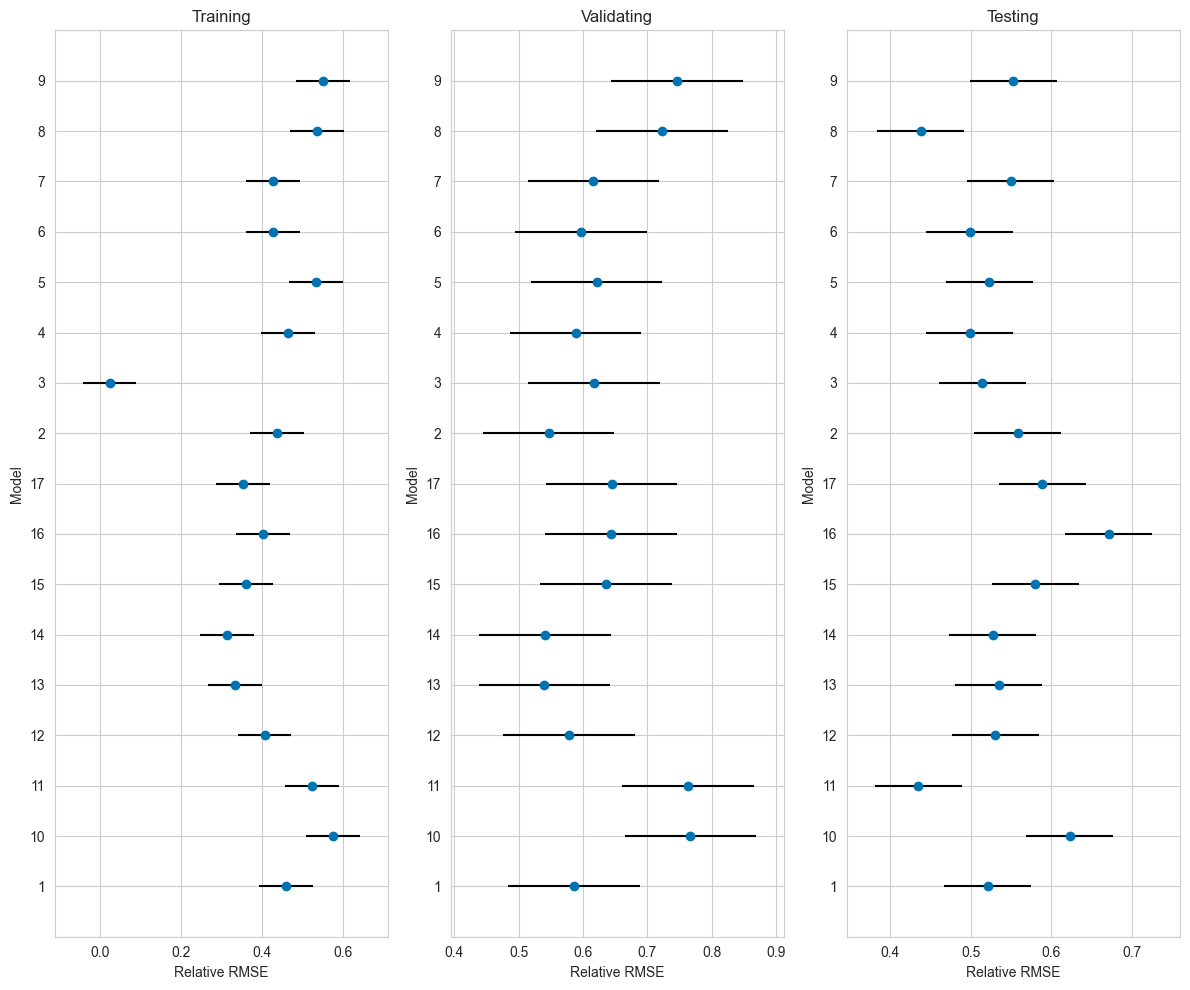

In [15]:
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind")
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Plot on each subplot (replace tukey1, tukey2, tukey3 with your objects)
tukey_train.plot_simultaneous(None, figsize=(12, 10), xlabel='Relative RMSE', ylabel='Model', ax=axes[0])
tukey_val.plot_simultaneous(None, figsize=(12, 10), xlabel='Relative RMSE', ylabel='Model', ax=axes[1])
tukey_test.plot_simultaneous(None, figsize=(12, 10), xlabel='Relative RMSE', ylabel='Model', ax=axes[2])

# Apply settings to all subplots
for ax, title in zip(axes,['Training','Validating','Testing']):
    ax.grid(True)
    ax.set_title(title)

    lines = ax.get_lines()
    for j, line in enumerate(lines):
        line.set_color(colors[j % len(colors)])

plt.tight_layout()
plt.show()


# Correctness

In [2]:
import pandas as pd
cox2_correctness = pd.read_csv('COX2/COX2_correctness.csv')
cdk2_correctness = pd.read_csv('CDK2/CDK2_correctness.csv')

In [3]:
cox2_correctness['Model 14'] = cox2_correctness['Model 12']

In [4]:
cox2_pivot = pd.melt(cox2_correctness,var_name="Model",value_name="Correctness").pivot_table(index='Model',values='Correctness',aggfunc='max').drop('Model draft',axis=0)
cox2_pivot = cox2_pivot.reset_index()

In [5]:
cdk2_pivot = pd.melt(cdk2_correctness,var_name="Model",value_name="Correctness").pivot_table(index='Model',values='Correctness',aggfunc='max')
cdk2_pivot = cdk2_pivot.reset_index()

In [6]:
correctness_merge = cox2_pivot.merge(cdk2_pivot,on='Model',suffixes=('_COX2','_CDK2'))

In [7]:
correctness_merge['id'] = [1,10,11,12,13,14,15,16,17,2,4,5,6,7,8,9]
correctness_merge = correctness_merge.sort_values('id')

In [8]:
correctness_merge

,Model,Correctness_COX2,Correctness_CDK2,id
0,Model 1,0.468585,0.477061,1
9,Model 2,0.417220,0.433918,2
10,Model 4,0.531699,0.398238,4
11,Model 5,0.411255,0.595678,5
12,Model 6,0.477710,0.468330,6
13,Model 7,0.698621,0.454030,7
14,Model 8,0.460226,0.439021,8
15,Model 9,0.470358,0.349325,9
1,Model 10,0.517885,0.421965,10
2,Model 11,0.754859,0.193243,11


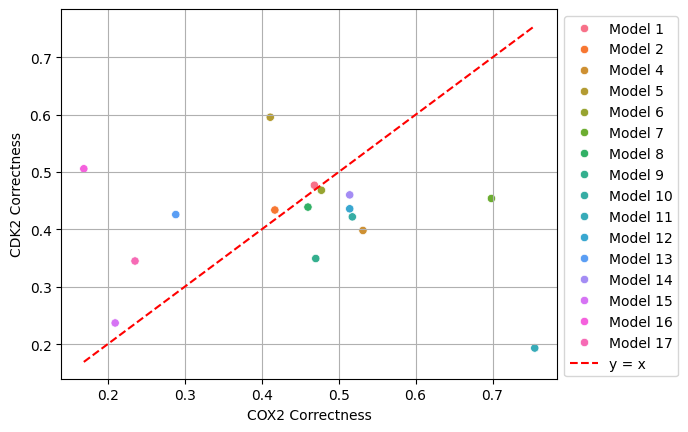

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Scatter plot with hue for different models
ax = sns.scatterplot(data=correctness_merge, x='Correctness_COX2', y='Correctness_CDK2', hue='Model')

# Add a diagonal line (y = x)
min_val = min(correctness_merge['Correctness_COX2'].min(), correctness_merge['Correctness_CDK2'].min())
max_val = max(correctness_merge['Correctness_COX2'].max(), correctness_merge['Correctness_CDK2'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Labels and grid
plt.xlabel('COX2 Correctness')
plt.ylabel('CDK2 Correctness')
plt.grid()

# Adjust legend to avoid covering points
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Moves legend outside plot
plt.show()

# Correctness versus Performance

In [10]:
import json

In [11]:
with open('COX2/COX2_test_metrics.json','r') as f:
    cox2_test_metrics = json.load(f)

with open('CDK2/CDK2_test_metrics.json','r') as f:
    cdk2_test_metrics = json.load(f)

In [12]:
cox2_test_metrics = pd.DataFrame(cox2_test_metrics)
cox2_test_metrics = cox2_test_metrics.iloc[:,:17].drop('RMSE_3',axis=1)
cox2_test_metrics = cox2_test_metrics/1.664394
cox2_test_metrics = cox2_test_metrics.melt(var_name='Model',value_name='RMSE').pivot_table(index='Model',values='RMSE',aggfunc='mean').reset_index()

In [13]:
cdk2_test_metrics = pd.DataFrame(cdk2_test_metrics)
cdk2_test_metrics = cdk2_test_metrics.iloc[:,:17].drop('RMSE_3',axis=1)
cdk2_test_metrics = cdk2_test_metrics/1.30
cdk2_test_metrics = cdk2_test_metrics.melt(var_name='Model',value_name='RMSE').pivot_table(index='Model',values='RMSE',aggfunc='mean').reset_index()

In [14]:
test_metrics = cdk2_test_metrics.merge(cox2_test_metrics,on='Model',suffixes=('_CDK2','_COX2'))
test_metrics['id'] = [1,10,11,12,13,14,15,16,17,2,4,5,6,7,8,9]

In [15]:
df_total = correctness_merge.merge(test_metrics,on='id')

In [16]:
df_total

,Model_x,Correctness_COX2,Correctness_CDK2,id,Model_y,RMSE_CDK2,RMSE_COX2
0,Model 1,0.468585,0.477061,1,RMSE_1,0.547486,0.589901
1,Model 2,0.417220,0.433918,2,RMSE_2,0.535026,0.567228
2,Model 4,0.531699,0.398238,4,RMSE_4,0.478618,0.564751
3,Model 5,0.411255,0.595678,5,RMSE_5,0.528553,0.623079
4,Model 6,0.477710,0.468330,6,RMSE_6,0.513435,0.566901
5,Model 7,0.698621,0.454030,7,RMSE_7,0.551777,0.657049
6,Model 8,0.460226,0.439021,8,RMSE_8,0.448648,0.565527
7,Model 9,0.470358,0.349325,9,RMSE_9,0.534173,0.610298
8,Model 10,0.517885,0.421965,10,RMSE_10,0.620006,0.639798
9,Model 11,0.754859,0.193243,11,RMSE_11,0.494306,0.602750


In [17]:
df_total = df_total.drop('Model_y', axis=1)

In [167]:
path = 'CDK2/focus_dataset/'
model = models.MPNN.load_from_checkpoint(path+'hyperparam_optim_3/best_checkpoint.ckpt')

In [168]:
#model_df = {'id': [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
            #'w_i_cdk2': [],
            #'w_h_cdk2': [],
            #'w_o_cdk2': [],
            #'depth_cdk2': [],
            #'ffn_depth_cdk2': []}

model_params = extract_params(model)
model_df['w_i_cdk2'].append(model_params['W_i'].shape[0])
model_df['w_h_cdk2'].append(model_params['W_h'].shape[0])
model_df['w_o_cdk2'].append(model_params['W_o'].shape[0])
model_df['depth_cdk2'].append(model_params['depth'])
model_df['ffn_depth_cdk2'].append(model_params['ffn_depth'])

In [169]:
model_df = pd.DataFrame(model_df)
model_df

,id,w_i_cdk2,w_h_cdk2,w_o_cdk2,depth_cdk2,ffn_depth_cdk2
0,1,400,400,400,3,3
1,2,1500,1500,1500,5,2
2,4,700,700,700,5,2
3,5,300,300,300,5,2
4,6,1900,1900,1900,2,2
5,7,2000,2000,2000,5,2
6,8,900,900,900,5,2
7,9,1300,1300,1300,2,2
8,10,2300,2300,2300,2,3
9,11,1300,1300,1300,2,3


In [170]:
df_total = df_total.merge(model_df,on='id')

In [34]:
import scipy
from scipy.stats import kendalltau

Y = pd.concat([df_total['Correctness_COX2'], df_total['Correctness_CDK2']],axis=0)
X = pd.concat([df_total['RMSE_COX2'],df_total['RMSE_CDK2']],axis=0)
scipy.stats.spearmanr(X,Y)

SignificanceResult(statistic=np.float64(-0.021996150766014164), pvalue=np.float64(0.9048849840143347))

(0.4, 0.8)

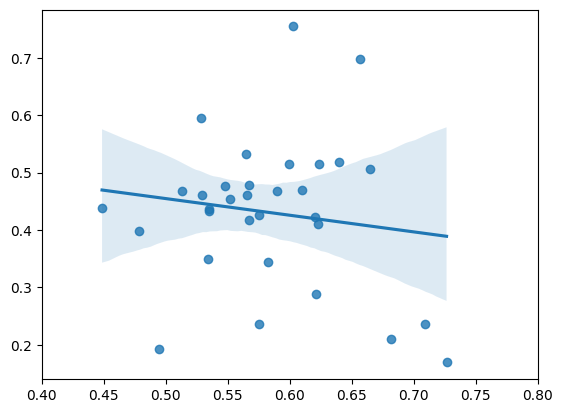

In [33]:
sns.regplot(x=X,y=Y)
plt.xlim(0.4,0.8)


In [2]:
with open('COX2/COX2_faithfulness.json', 'r') as f:
    faithfulness_scores =json.load(f)

In [7]:
np.mean(faithfulness_scores['Model_16'])

np.float64(0.8184692100214432)